![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta, datetime # работа с датами
import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем библиотеки длчя работы с анализом тональности 
from textblob import TextBlob # Sentiment analysis

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/world-cities/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [131]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [132]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

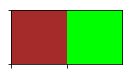

In [133]:
# Определяем цвета для разных графиков
colors = ['Brown', 'Lime']
sns.palplot(sns.color_palette(colors))

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
world_cities_df = pd.read_csv('/kaggle/input/world-cities/worldcities.csv')
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18908,id_4800,Berlin,"['Cafe', 'German', 'International', 'Vegetaria...",4802.0,$,3.0,"[[], []]",/Restaurant_Review-g187323-d6874663-Reviews-Ca...,d6874663,1,4.5
40436,id_572,Copenhagen,"['Cafe', 'European', 'Danish', 'International'...",573.0,$$ - $$$,97.0,"[['Great place for lunch', 'Great place to vis...",/Restaurant_Review-g189541-d951483-Reviews-Pix...,d951483,1,4.0
21954,id_957,Dublin,"['Irish', 'Cafe', 'International', 'Pub', 'Gas...",959.0,$$ - $$$,17.0,"[['Busy', 'Great pub'], ['08/07/2017', '07/11/...",/Restaurant_Review-g186605-d10029993-Reviews-T...,d10029993,1,4.0
384,id_384,Copenhagen,"['European', 'Scandinavian', 'Danish']",154.0,$$ - $$$,283.0,"[['Bistro serving modern Danish food', 'Incred...",/Restaurant_Review-g189541-d4290685-Reviews-Kj...,d4290685,0,0.0
3793,id_3793,Edinburgh,"['French', 'European', 'Vegetarian Friendly', ...",73.0,$$ - $$$,1424.0,"[['Lovely lunch', 'Fantastic little French bis...",/Restaurant_Review-g186525-d720297-Reviews-Pet...,d720297,0,0.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Restaurant_id                            0.0%
City                                     0.0%
Cuisine Style                            0.0%
Ranking                                  0.0%
Price Range                              35.0%
Number of Reviews                        6.0%
Reviews                                  0.0%
URL_TA                                   0.0%
ID_TA                                    0.0%
sample                                   0.0%
Rating                                   0.0%


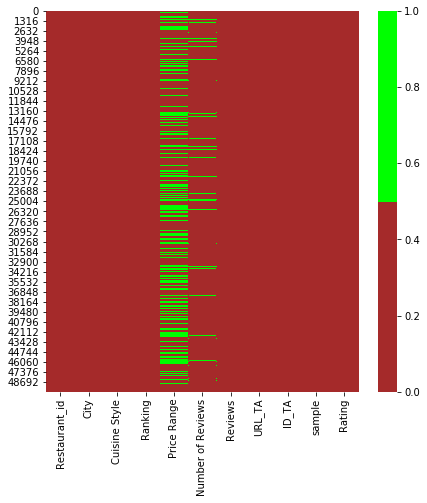

In [138]:
# Смотрим где у нас есть пропуски, в каких столбцах
# Графически
def check_nans(df_input):
    columns = df_input.columns
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(df_input[columns].isnull(), cmap=sns.color_palette(colors))

    max_len = 40
    # Процентное содержание пропусков в столбцах
    for column in df_input.columns:
        pct_missing = np.mean(df_input[column].isnull())
        print("{} {}{}%".format(column," " * (max_len-len(column)), round(pct_missing*100)))
        
check_nans(df)

Фиксируем наличие пропусков в 3 столбцах - 'Cuisine Style', 'Price Range' и 'Number of Reviews'
Остальные столбци не имеют пропусков.

In [16]:
# Для примера я возьму столбец Number of Reviews
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [17]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
df['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [18]:
df.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?
Скорее всего при первом взгляде и руководствуясь здавым смыслом категоральные признаки будут:
* City
* Cuisine Style
* Price Range (возможно)                

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [19]:
# Experimental DF
# 
ex_df = df.copy()
ex_df = ex_df.drop(['ID_TA', 'URL_TA'], axis = 1)
ex_df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Number_of_Reviews_isNAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",0,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0


#### Возьмем следующий признак "Price Range".

In [20]:
ex_df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [21]:
# Попробуем разные способы обработки
# Строковое (или категориальное) значение
def fill_price_range_str(price):
    if pd.isna(price):
        return price
    elif price == '$':
        return 'cheap'
    elif price == '$$ - $$$':
        return 'medium'
    elif price == "$$$$":
        return 'expensive'
    else:
        return 'uknown'

# Или же числовое значение ()
def fill_price_range_int(price):
    if pd.isna(price):
        return price
    elif price == '$':
        return 1
    elif price == '$$ - $$$':
        return 2
    elif price == "$$$$":
        return 3
    else:
        return -1
    
# Проблема с этим признаком в том, что примерно 35% значений незаполненны
ex_df['Price Range'] = ex_df['Price Range'].apply(fill_price_range_str)
ex_df['Price Range'] = ex_df['Price Range'].fillna('uknown')
ex_df['Price Range'].value_counts()

medium       23041
uknown       17361
cheap         7816
expensive     1782
Name: Price Range, dtype: int64

In [22]:
# Можно посмотреть разные корреляции
# method must be either 'pearson', 'spearman', 'kendall', or a callable, 'kattle'
def display_correlation(data):
    print('Spearman')
    display(data.corr(method='spearman'))
    print('Pearson')
    display(data.corr(method='pearson'))
    print('Kendall')
    display(data.corr(method='kendall'))
# display_correlation(ex_df)

def draw_heatmap(data):
    plt.rcParams['figure.figsize'] = (30,20)
    sns.heatmap(data.corr(),)

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [23]:
# Ваша обработка 'Price Range'
# Обрабатываем и смотрим корреляции для категорального типа значений 'Price Range'
ex_df = df.copy()
ex_df = ex_df.drop(['ID_TA', 'URL_TA'], axis = 1)
# ex_df['Price Range Uknown'] = pd.isna(ex_df['Price Range']).astype('uint8')
# ex_df['Price Range Uknown'] = ex_df['Price Range Uknown'].fillna(0, inplace=True)
ex_df['Price Range'] = ex_df['Price Range'].apply(fill_price_range_str)
ex_df['Price Range'] = ex_df['Price Range'].fillna('uknown')

ex_df = pd.get_dummies(ex_df, columns=['Price Range'], dummy_na=False)
# display_correlation(ex_df)

In [24]:
# Обрабатываем и смотрим корреляции для числового типа значений 'Price Range'
ex_df = df.copy()
ex_df = ex_df.drop(['ID_TA', 'URL_TA'], axis = 1)
ex_df['Price Range Uknown'] = pd.isna(ex_df['Price Range']).astype('uint8')
ex_df['Price Range Uknown'] = ex_df['Price Range Uknown'].fillna(0, inplace=True)
ex_df['Price Range'] = ex_df['Price Range'].apply(fill_price_range_int)
ex_df['Price Range'] = ex_df['Price Range'].fillna(0)
# display_correlation(ex_df)
# Использовал разные значения для замены $ $$ $$$ на 1, 2 ,3 так же на 10, 50, 100 - корреляция Raiting практически не менялась,
# оставаясь в районе -0.0238 для Spearmen если использовать медианное значение для заполнения пропусков

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

In [25]:
# Получаем лучший результат если переводим 'Price Range' в категоральный признак
ex_df = df.copy()
ex_df = ex_df.drop(['ID_TA', 'URL_TA'], axis = 1)
# ex_df['Price Range Uknown'] = pd.isna(ex_df['Price Range']).astype('uint8')
# ex_df['Price Range Uknown'] = ex_df['Price Range Uknown'].fillna(0, inplace=True)
ex_df['Price Range'] = ex_df['Price Range'].apply(fill_price_range_str)
ex_df['Price Range'] = ex_df['Price Range'].fillna('uknown')

ex_df = pd.get_dummies(ex_df, columns=['Price Range'], dummy_na=False)

In [26]:
ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
Reviews                    49998 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Price Range_cheap          50000 non-null uint8
Price Range_expensive      50000 non-null uint8
Price Range_medium         50000 non-null uint8
Price Range_uknown         50000 non-null uint8
dtypes: float64(3), int64(1), object(4), uint8(5)
memory usage: 3.3+ MB


### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [27]:
# тут ваш код на обработку других признаков
# .....

# Чистим Кухню
ex_df['Cuisine Style'] = ex_df['Cuisine Style'].fillna("['Not Specified']")
def get_unique_cuisines_list(df):
    cuisines_list = list()
    for cuisine in df:
        cuisines_list += cuisine

    cuisines_list = list(set([x.strip() for x in cuisines_list]))
    return sorted(cuisines_list)

def clean_cuisine(cuisine):
    tmp = cuisine[1:-1].replace("'","").split(',')
    cuisines_list = list(set([x.strip() for x in tmp]))
    return sorted(cuisines_list)

# Получаем Даммиес из кухни
def get_dummies_from_cuisine(data):
    # Step 1
    # This step applies pd.Series to your lists which splits each item in your lists to a new column. 
    # stack then stacks these columns into one single column while maintaining important index info. 
    # The reset_index part resets level 1 of the index and drops it because it's not needed.
    tmp_series = data['Cuisine Style'].apply(pd.Series).stack().reset_index(1, drop=True)

    # Step 2
    # Now we are transferring this series into a DataFrame with one column
    tmp_data = pd.DataFrame(tmp_series, columns=['Cuisine Style'])

    # Step 3
    # Here, we finally call the get_dummies and we use the columns=['Cuisine Style'] to specifically tell get_dummies 
    # to only get dummies for the Cuisine Style column.
    dummies_df = (pd.get_dummies(tmp_data, columns=['Cuisine Style']))

    # Step 4
    # Lastly you use a groupby on by index (cos this is the only unique field there we have)
    # Then sum that result with .sum()
    return dummies_df.groupby(dummies_df.index).sum()

# .....
# Чистим и обрабатываем города
def process_cities(data, city_data):
    list_of_cities = list(data.City.value_counts().index)
    list_of_cities
    data['population'] = np.nan
    data['capital'] = np.nan

    for city in list_of_cities:
        print(city)
        tmp_df = city_data[(city_data.city_ascii == city)]
        population = tmp_df.population.max()
        capital = tmp_df[tmp_df.population == population].capital.iloc[0]
        data.loc[data.City == city, ['population']] = population
        data.loc[data.City == city, ['capital']] = capital
    return pd.get_dummies(data, columns=['capital'], dummy_na=False)


def process_reviews(data):
    lrx = re.compile('\[\[.*\]\]')
    nan = None
    cell = data['reviews']
    tmp_list = [[], []]  # Temp list для хранения промежуточного результата
    if type(cell) == str and lrx.fullmatch(cell):
        tmp_list = eval(cell)

    data['first_review'] = tmp_list[0][1] if len(tmp_list[0]) > 1 else nan
    data['last_review'] = tmp_list[0][0] if len(tmp_list[0]) > 0 else nan

    data['first_date'] = pd.to_datetime(
        tmp_list[1][1] if len(tmp_list[1]) > 1 else nan)
    data['last_date'] = pd.to_datetime(tmp_list[1][0] if len(
        tmp_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    data['first_date'] = pd.to_datetime(data['first_date'])
    data['last_date'] = pd.to_datetime(data['last_date'])

    return data

In [28]:
# Кухня
ex_df['Cuisine Style'] = ex_df['Cuisine Style'].apply(clean_cuisine)
cuisines = get_unique_cuisines_list(ex_df['Cuisine Style'])
result = get_dummies_from_cuisine(ex_df)
ex_df = pd.concat([ex_df, result], axis=1)
ex_df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,sample,Rating,Number_of_Reviews_isNAN,Price Range_cheap,...,Cuisine Style_Ukrainian,Cuisine Style_Uzbek,Cuisine Style_Vegan Options,Cuisine Style_Vegetarian Friendly,Cuisine Style_Venezuelan,Cuisine Style_Vietnamese,Cuisine Style_Welsh,Cuisine Style_Wine Bar,Cuisine Style_Xinjiang,Cuisine Style_Yunnan
0,id_0,Paris,"[Bar, Pub]",12963.0,4.0,"[[], []]",0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Gluten Free Options, Scandinavian, ...",106.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,id_3,London,"[European, Gluten Free Options, Italian, Medit...",1669.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,id_4,Bratislava,"[European, Gluten Free Options, Italian, Medit...",37.0,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
# Обрабатываем 'City'. Смотрим на пропуски - пропусков нет.
ex_df.City.fillna('Uknown City')
ex_df.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [30]:
# Значит нужно что-то делать с данной колонкой - это явно категоральный признак и нужно с ним что-то делать
# Можно извлечь из данного признака дамми-переменные, а можно попробовать другой подходю
# Например само по себе название города не имеет никакой ценности для анализа данных
# но по названию города можно найти много другой информации - население, столица или нет и тд.
# Попробуем заменить город на эти данные
# В нашем датасете стоит самоназвание столицы Португалии - Oporto
# А в датасете с информацией по городам мира - Porto, поэтому переименовываем
ex_df.loc[df.City == 'Oporto', ['City']] = 'Porto'
tmp_res = process_cities(ex_df, world_cities_df)
tmp_res.head()

London
Paris
Madrid
Barcelona
Berlin
Milan
Rome
Prague
Lisbon
Vienna
Amsterdam
Brussels
Hamburg
Munich
Lyon
Stockholm
Budapest
Warsaw
Dublin
Copenhagen
Athens
Edinburgh
Zurich
Porto
Geneva
Krakow
Oslo
Helsinki
Bratislava
Luxembourg
Ljubljana


,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,sample,Rating,Number_of_Reviews_isNAN,Price Range_cheap,...,Cuisine Style_Vegetarian Friendly,Cuisine Style_Venezuelan,Cuisine Style_Vietnamese,Cuisine Style_Welsh,Cuisine Style_Wine Bar,Cuisine Style_Xinjiang,Cuisine Style_Yunnan,population,capital_admin,capital_primary
0,id_0,Paris,"[Bar, Pub]",12963.0,4.0,"[[], []]",0,0.0,0,0,...,0,0,0,0,0,0,0,11020000.0,0,1
1,id_1,Helsinki,"[European, Gluten Free Options, Scandinavian, ...",106.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,...,1,0,0,0,0,0,0,642045.0,0,1
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,...,1,0,0,0,0,0,0,488050.0,0,0
3,id_3,London,"[European, Gluten Free Options, Italian, Medit...",1669.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0,0,...,1,0,0,0,0,0,0,10979000.0,0,1
4,id_4,Bratislava,"[European, Gluten Free Options, Italian, Medit...",37.0,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0,0,...,1,0,0,0,0,0,0,429564.0,0,1


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

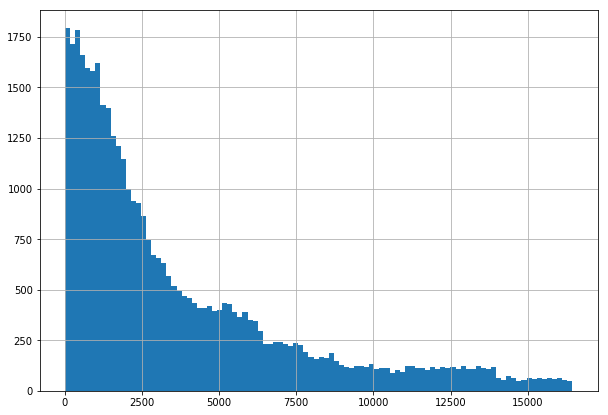

In [31]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

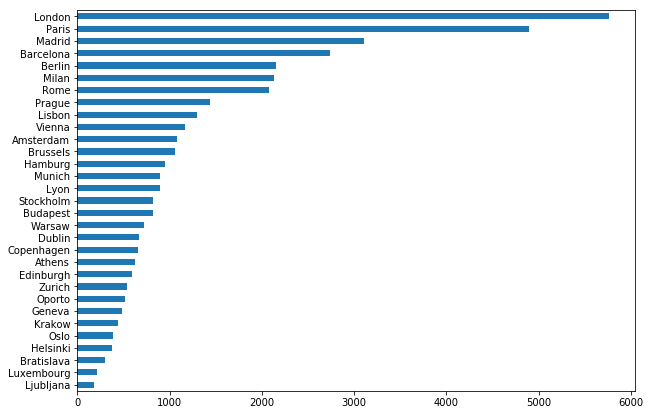

In [32]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

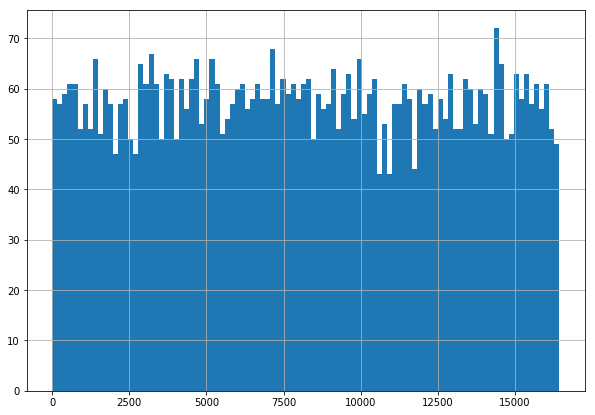

In [33]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

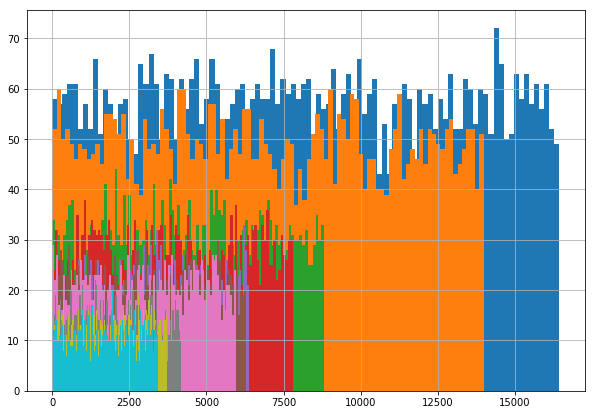

In [34]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

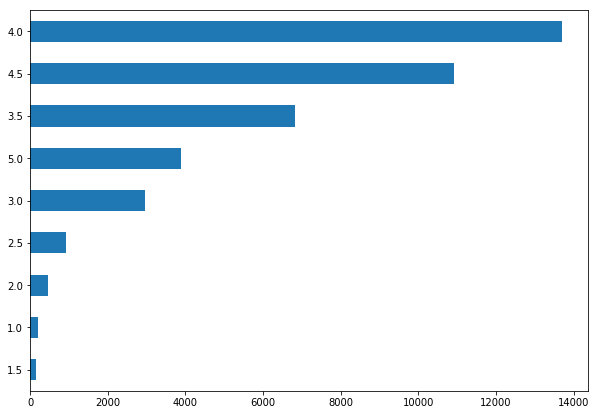

In [35]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

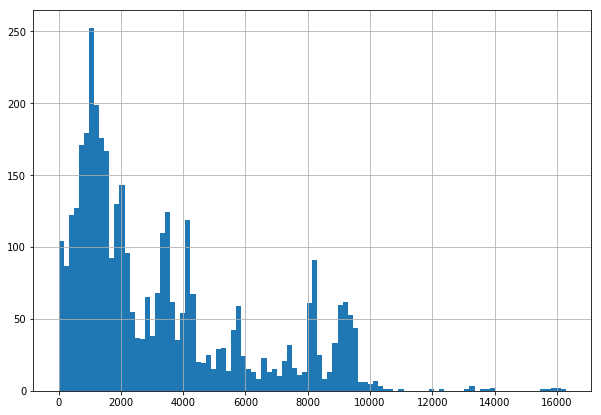

In [36]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

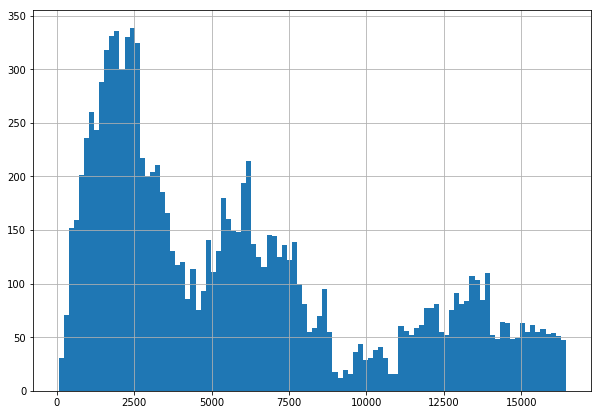

In [37]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Text(0.5, 0, 'Rating')

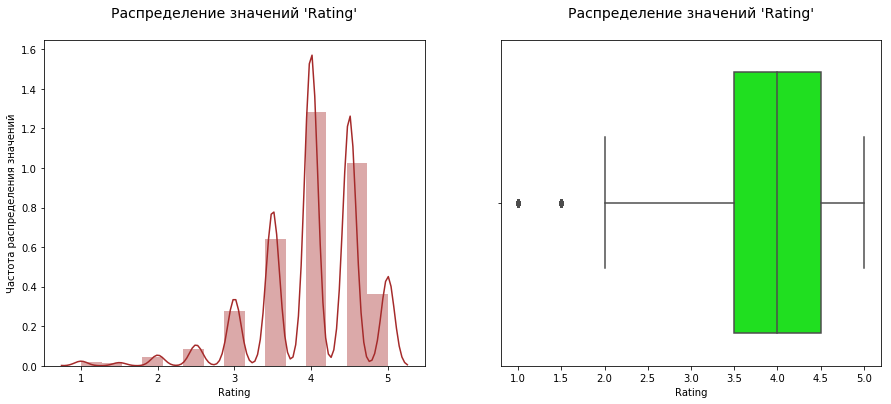

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(df_train.Rating.values, bins=15, color=colors[0])
plt.title("Распределение значений 'Rating'\n", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Частота распределения значений")

plt.subplot(122)
sns.boxplot(df_train.Rating.values, color=colors[1])
plt.title("Распределение значений 'Rating'\n", fontsize=14)
plt.xlabel("Rating")

In [39]:
df_train['Rating'].describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

Целевая переменная распределенна нормально со смещением вправо.

### Столбец Ranking
Данный столбец имеет наибольшую корреляцию с целевой переменной.
Давайте посмотрим как распределение имеет данный признак

Text(0.5, 0, 'Ranking')

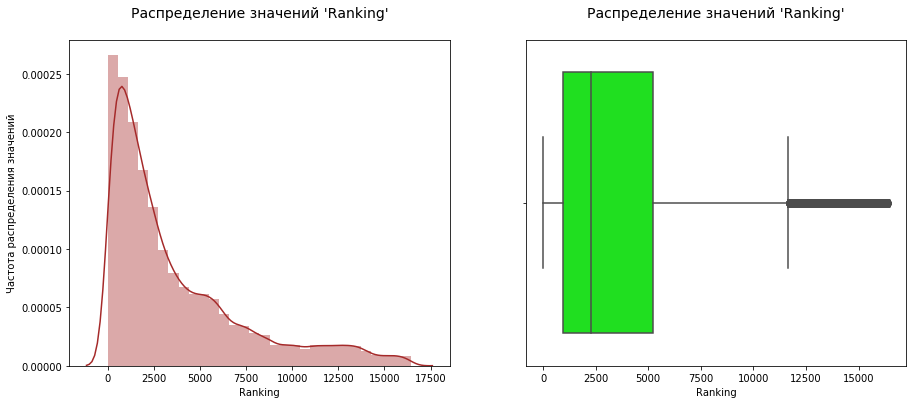

In [40]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(df['Ranking'].values, bins=30, color=colors[0])
plt.title("Распределение значений 'Ranking'\n", fontsize=14)
plt.xlabel("Ranking")
plt.ylabel("Частота распределения значений")

plt.subplot(122)
sns.boxplot(df['Ranking'].values, color=colors[1])
plt.title("Распределение значений 'Ranking'\n", fontsize=14)
plt.xlabel("Ranking")

In [41]:
df['Ranking'].describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

Значение 'Ranking' тоже имеет нормальное распределение со смещением влево. Имеется какое-то количество выбросов.

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

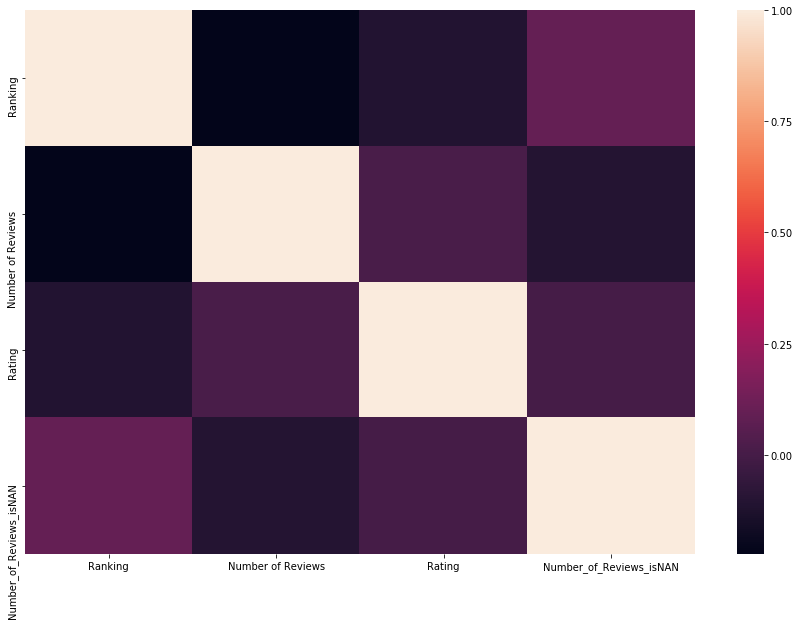

In [42]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [100]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
world_cities_df = pd.read_csv('/kaggle/input/world-cities/worldcities.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями


df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [101]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


### 1. Чистим кухню

In [102]:
# Чистим Кухню
def get_unique_cuisines_list(df):
    cuisines_list = list()
    for cuisine in df:
        cuisines_list += cuisine

    cuisines_list = list(set([x.strip() for x in cuisines_list]))
    return sorted(cuisines_list)

def clean_cuisine(cuisine):
    tmp = eval(cuisine)
    cuisines_list = list(set([x.strip() for x in tmp]))
    return sorted(cuisines_list)

# Получаем Даммиес из кухни
def get_dummies_from_cuisine(df):
    # Step 1
    # This step applies pd.Series to your lists which splits each item in your lists to a new column. 
    # stack then stacks these columns into one single column while maintaining important index info. 
    # The reset_index part resets level 1 of the index and drops it because it's not needed.
    tmp_series = df['Cuisine Style'].apply(pd.Series).stack().reset_index(1, drop=True)

    # Step 2
    # Now we are transferring this series into a DataFrame with one column
    tmp_data = pd.DataFrame(tmp_series, columns=['Cuisine Style'])

    # Step 3
    # Here, we finally call the get_dummies and we use the columns=['Cuisine Style'] to specifically tell get_dummies 
    # to only get dummies for the Cuisine Style column.
    dummies_df = (pd.get_dummies(tmp_data, columns=['Cuisine Style']))

    # Step 4
    # Lastly you use a groupby on by index (cos this is the only unique field there we have)
    # Then sum that result with .sum()
    return pd.concat([df, dummies_df.groupby(dummies_df.index).sum()], axis=1)

In [103]:
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Not Specified']")
df['Cuisine Style'] = df['Cuisine Style'].apply(clean_cuisine)
working_df = get_dummies_from_cuisine(df)

In [104]:
working_df.drop(['Cuisine Style', 'Restaurant_id','ID_TA', 'URL_TA'], axis = 1, inplace=True)
display(working_df.head())

,City,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Cuisine Style_Afghani,Cuisine Style_African,Cuisine Style_Albanian,...,Cuisine Style_Ukrainian,Cuisine Style_Uzbek,Cuisine Style_Vegan Options,Cuisine Style_Vegetarian Friendly,Cuisine Style_Venezuelan,Cuisine Style_Vietnamese,Cuisine Style_Welsh,Cuisine Style_Wine Bar,Cuisine Style_Xinjiang,Cuisine Style_Yunnan
0,Paris,12963.0,$$ - $$$,4.0,"[[], []]",0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Helsinki,106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,Edinburgh,810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,London,1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bratislava,37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Чистим

In [109]:
# Переводим Price Range  в строковое (или категориальное) значение 
def fill_price_range_str(price):
    if pd.isna(price):
        return price
    elif price == '$':
        return 'cheap'
    elif price == '$$ - $$$':
        return 'medium'
    elif price == "$$$$":
        return 'expensive'
    else:
        return 'uknown'

# .....
# Чистим и обрабатываем города
def process_cities(df_input, city_data):
    df_output = df_input.copy()
    df_output.loc[df_input.City == 'Oporto', ['City']] = 'Porto'
    list_of_cities = list(df_output.City.value_counts().index)
    list_of_cities
    df_output['population'] = np.nan
    df_output['capital'] = np.nan

    for city in list_of_cities:
        print(city)
        tmp_df = city_data[(city_data.city_ascii == city)]
        population = tmp_df.population.max()
        capital = tmp_df[tmp_df.population == population].capital.iloc[0]
        df_output.loc[df_output.City == city, ['population']] = population
        df_output.loc[df_output.City == city, ['capital']] = capital
    return df_output


def process_reviews(df_input):
    df_output = df_input.copy()
    lrx = re.compile('\[\[.*\]\]')
    cell = df_input['Reviews']
    nan = None
    tmp_list = [[], []]
    if type(cell) == str and lrx.fullmatch(cell):  # compare with searech template
        tmp_list = eval(cell)  # transform into a list

    df_output['first_review'] = tmp_list[0][1] if len(tmp_list[0]) > 1 else nan
    df_output['last_review'] = tmp_list[0][0] if len(tmp_list[0]) > 0 else nan

    df_output['first_date'] = pd.to_datetime(tmp_list[1][1] if len(tmp_list[1]) > 1 else nan)
    df_output['last_date'] = pd.to_datetime(tmp_list[1][0] if len(tmp_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    df_output['first_date'] = pd.to_datetime(df_output['first_date'])
    df_output['last_date'] = pd.to_datetime(df_output['last_date'])

    return df_output


# Функция для перевода даты в дни
def get_days(timedelta):
    return abs(timedelta.days)


def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#     df_output.drop(['Restaurant_id','ID_TA', 'URL_TA'], axis = 1, inplace=True)


    print("# ################### 2. NAN ###############################################################")
    # Мы определили наличие пропусков только в 3 столбцах 
    # - 'Cuisine Style', 'Price Range' и 'Number of Reviews'
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].mean(), inplace=True)

    # Для колонок 'Price Range' и 'Cuisine Style' заполняем значением 'unknown' не вынося их в отдельную
    # колонку, потому что всё равно будем извлекать из этих колонок dummy variables    
    df_output['Price Range'] = df_output['Price Range'].fillna('uknown')
#     df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['uknown']")
    display(df_output.head())

    
    print("# ################### 3. Feature Engineering ###############################################")
    # тут ваш код не генерацию новых фитчей
    # ....
    # Пробуем извлеч что-либо из Ranking
    # 1. Найдём общее количество ресторанов в каждом городе в датасете
    df_output = process_cities(df_output, world_cities_df)
    city_restaurant = dict(df_output['City'].value_counts())
    df_output['Restaurant Qty'] = df_output['City'].map(city_restaurant)
    # 2. После этого разделим данные в Ranking на количество ресторанов в городе
    df_output['Relative Ranking'] = df_output['Ranking']/df_output['Restaurant Qty']

    # 3. Также вычислим сколько в среднем людей приходится на городской ресторан исходя из количества населения
    # PPR - People Per Restaurant
    df_output['PPR'] = df_output['population']/df_output['Restaurant Qty']
    
    # 4. Обрабатываем отзывы
    df_output = df_output.apply(process_reviews, axis=1)
    # Находим дельту между первым и последним отзывом
    df_output['Timedelta'] = df_output['last_date'] - df_output['first_date']
    # Переводим это в дни
    df_output['Timedelta'] = df_output['Timedelta'].apply(get_days)
    now = datetime.now()
    CURRENT_DATE = pd.to_datetime("{}/{}/{}".format(now.day, now.month, now.year))
    df_output['days_between_rev'] = df_output['last_date'].apply(lambda date: CURRENT_DATE - date)
    df_output['days_between_rev'] = df_output['days_between_rev'].apply(get_days)

    
    print("# ################### 4. Encoding ##########################################################")
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # Кухня
    # df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Not Specified']")
    # df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(clean_cuisine)
    # df_output = get_dummies_from_cuisine(df_output)
    
    # Города
    df_output = pd.get_dummies(df_output, columns=['City',], dummy_na=True)
    
    # Price Range
    df_output['Price Range'] = df_output['Price Range'].apply(fill_price_range_str)
    df_output['Price Range'] = df_output['Price Range'].fillna('uknown')
    df_output = pd.get_dummies(df_output, columns=['Price Range'], dummy_na=True)


    print("# ################### 5. Clean ##############################################################")
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [110]:
df_preproc = preproc_data(working_df)
df_preproc.sample(10)

# ################### 2. NAN ###############################################################


,City,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Cuisine Style_Afghani,Cuisine Style_African,Cuisine Style_Albanian,...,Cuisine Style_Uzbek,Cuisine Style_Vegan Options,Cuisine Style_Vegetarian Friendly,Cuisine Style_Venezuelan,Cuisine Style_Vietnamese,Cuisine Style_Welsh,Cuisine Style_Wine Bar,Cuisine Style_Xinjiang,Cuisine Style_Yunnan,Number_of_Reviews_isNAN
0,Paris,12963.0,$$ - $$$,4.0,"[[], []]",0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Helsinki,106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,Edinburgh,810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,London,1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Bratislava,37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# ################### 3. Feature Engineering ###############################################
London
Paris
Madrid
Barcelona
Berlin
Milan
Rome
Prague
Lisbon
Vienna
Amsterdam
Brussels
Hamburg
Munich
Lyon
Stockholm
Budapest
Warsaw
Dublin
Copenhagen
Athens
Edinburgh
Zurich
Porto
Geneva
Krakow
Oslo
Helsinki
Bratislava
Luxembourg
Ljubljana
# ################### 4. Encoding ##########################################################
# ################### 5. Clean ##############################################################


,Ranking,Number of Reviews,sample,Rating,Cuisine Style_Afghani,Cuisine Style_African,Cuisine Style_Albanian,Cuisine Style_American,Cuisine Style_Arabic,Cuisine Style_Argentinean,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range_cheap,Price Range_expensive,Price Range_medium,Price Range_uknown,Price Range_nan
32795,4541.0,42.000000,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17651,4244.0,124.471197,1,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13887,1555.0,192.000000,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30332,875.0,41.000000,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45232,1863.0,60.000000,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20086,6406.0,230.000000,1,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8291,6012.0,11.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37792,1525.0,14.000000,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
31095,1446.0,7.000000,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20870,123.0,149.000000,1,4.5,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [112]:
df_preproc.head(20)

,Ranking,Number of Reviews,sample,Rating,Cuisine Style_Afghani,Cuisine Style_African,Cuisine Style_Albanian,Cuisine Style_American,Cuisine Style_Arabic,Cuisine Style_Argentinean,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range_cheap,Price Range_expensive,Price Range_medium,Price Range_uknown,Price Range_nan
0,12963.0,4.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,106.0,97.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,810.0,28.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1669.0,202.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,37.0,162.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,5093.0,24.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,3704.0,2.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,2330.0,124.471197,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,771.0,2.000000,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,605.0,13.000000,0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [116]:
df_preproc.to_csv('df_preproc.csv', index=False)
backup_df = df_preproc.copy()
df_preproc.drop(['first_date', 'last_date'], inplace=True, axis=1)

In [143]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [144]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [145]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 173), (40000, 173), (40000, 172), (32000, 172), (8000, 172))

# Model 
Сам ML

In [146]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [147]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

Ranking                                  0.0%
Number of Reviews                        0.0%
sample                                   0.0%
Rating                                   0.0%
Cuisine Style_Afghani                    0.0%
Cuisine Style_African                    0.0%
Cuisine Style_Albanian                   0.0%
Cuisine Style_American                   0.0%
Cuisine Style_Arabic                     0.0%
Cuisine Style_Argentinean                0.0%
Cuisine Style_Armenian                   0.0%
Cuisine Style_Asian                      0.0%
Cuisine Style_Australian                 0.0%
Cuisine Style_Austrian                   0.0%
Cuisine Style_Azerbaijani                0.0%
Cuisine Style_Balti                      0.0%
Cuisine Style_Bangladeshi                0.0%
Cuisine Style_Bar                        0.0%
Cuisine Style_Barbecue                   0.0%
Cuisine Style_Belgian                    0.0%
Cuisine Style_Brazilian                  0.0%
Cuisine Style_Brew Pub            

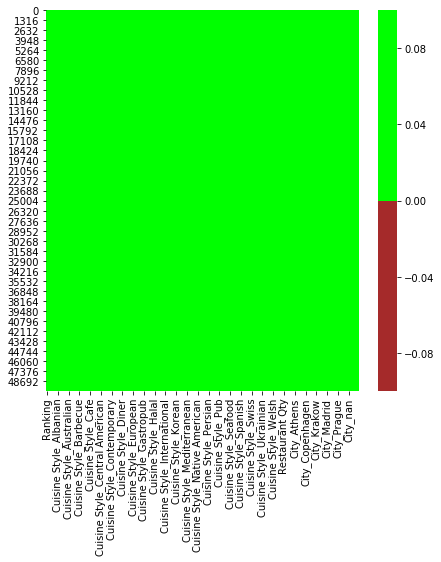

In [148]:
check_nans(df_preproc)

In [151]:
df_preproc = df_preproc.fillna(0)

In [152]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [153]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20189749999999998


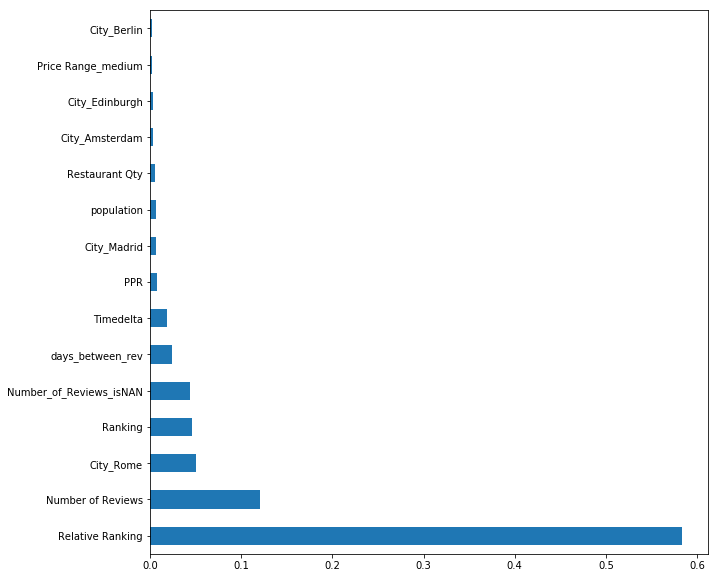

In [154]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [155]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Cuisine Style_Afghani,Cuisine Style_African,Cuisine Style_Albanian,Cuisine Style_American,Cuisine Style_Arabic,Cuisine Style_Argentinean,Cuisine Style_Armenian,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range_cheap,Price Range_expensive,Price Range_medium,Price Range_uknown,Price Range_nan
5437,72.0,271.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1294,4388.0,315.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6601,1629.0,14.0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
9157,2209.0,62.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6826,5513.0,79.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9262,1902.0,2.0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3757,594.0,233.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5204,5566.0,27.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8000,5183.0,2.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9096,11.0,366.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [156]:
test_data = test_data.drop(['Rating'], axis=1)

In [157]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [158]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [159]:
predict_submission

array([3.005, 4.23 , 4.455, ..., 3.08 , 4.47 , 4.34 ])

In [160]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.230
2,id_2,4.455
3,id_3,4.360
4,id_4,4.465
5,id_5,4.395
6,id_6,2.975
7,id_7,2.160
8,id_8,4.030
9,id_9,4.670


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
